## Time-Series Prediction
-by Qi Sun

***

The purpose of this study is to predict Superstore Sales on the category of technology. 

The dataset was downloaded from: https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls .
There are 9994 records and 21 columns in this dataset.

There are several categories in the Superstore sales data, I will perform time series analysis and forecasting for Technology sales.




In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [18]:
# read data from GitHub
df = pd.read_csv('https://raw.githubusercontent.com/susanq-isun/Superstore.csv')
df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/16,11/11/16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/16,11/11/16,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/16,6/16/16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/15,10/18/15,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/15,10/18/15,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
print(df.shape)
print(list(df.columns))

(9994, 21)
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Row ID,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.750,9994.000
Postal Code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
Sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
Quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
Discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
Profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


In [29]:
# check data type
df.dtypes

Row ID                    int64
Order ID                 object
Order Date               object
Ship Date                object
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
date             datetime64[ns]
dtype: object

In [25]:
# change the data type of 'order date' from string to date
df['date'] = pd.to_datetime(df['Order Date'])


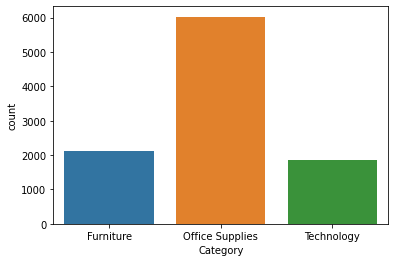

In [11]:
# plot the category column
sns.countplot(df['Category']);


In [46]:
# choose data in the category of 'Technology'
tech = df.loc[df['Category'] == 'Technology']


In [47]:
# check the date range
tech['date'].min(), tech['date'].max()
# the results show that I have a good 4-year technology sales data

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

### Data Preprocessing

#### Remove irrelevant columns

In [49]:
cols = ['Row ID', 'Order ID', 'Order Date','Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

tech.drop(cols, axis=1, inplace=True)


####  Check missing values

In [50]:
tech = tech.sort_values('date')

tech.isnull().sum()


Sales    0
date     0
dtype: int64

#### Aggregate sales by date

In [51]:
tech = tech.groupby('date')['Sales'].sum().reset_index()
tech.head()

,date,Sales
0,2014-01-06,1147.94
1,2014-01-09,31.20
2,2014-01-13,646.74
3,2014-01-15,149.95
4,2014-01-16,124.20


In [52]:
tech.tail()

,date,Sales
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376
823,2017-12-30,90.930


#### Split the data into training and testing subsets

Create train and test files for modeling. The data of 2014, 2015, and 2016 are used as training set, and the data of 2017 as testing set.


In [59]:
# create the trainging set
tech['year'] = tech['date'].apply(lambda x: x.year)
train = tech.loc[(tech['year'] == 2014) | (tech['year'] == 2015) | (tech['year'] == 2016)]
test = tech.loc[tech['year'] == 2017]


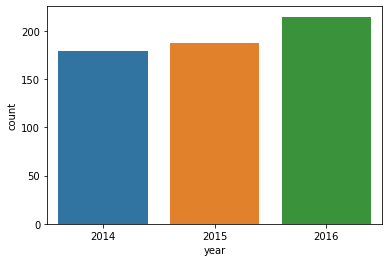

In [65]:
# plot the train year column
sns.countplot(train['year']);


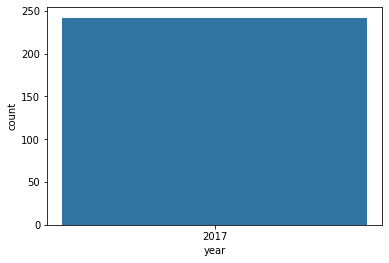

In [62]:
# plot the test year column
sns.countplot(test['year']);


In [89]:
train.drop(['year'], axis=1)

,date,Sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
577,2016-12-24,453.650
578,2016-12-25,3646.054
579,2016-12-26,392.354
580,2016-12-27,40.000


In [90]:
test.drop(['year'], axis=1)

,date,Sales
582,2017-01-02,712.290
583,2017-01-07,3059.982
584,2017-01-14,528.688
585,2017-01-15,110.576
586,2017-01-19,429.600
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


In [99]:
train02 = train.drop(['year'], axis=1)
test02 = test.drop(['year'], axis=1)


#### Reset index

In [100]:
train02 = train02.groupby('date')['Sales'].sum().reset_index()


In [101]:
test02 = test02.groupby('date')['Sales'].sum().reset_index()


#### Index with Time Series Data


In [102]:
train02 = train02.set_index('date')
test02 = test02.set_index('date')


#### Visualize Technology Sales Time Series Data

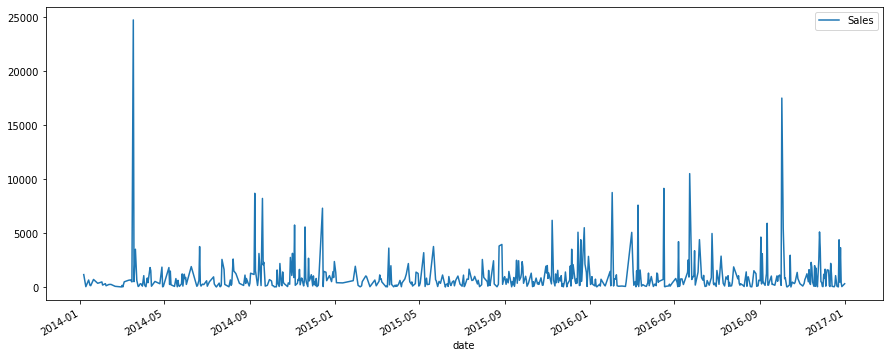

In [224]:
# train data set
train02.plot(figsize=(15, 6))
plt.show()


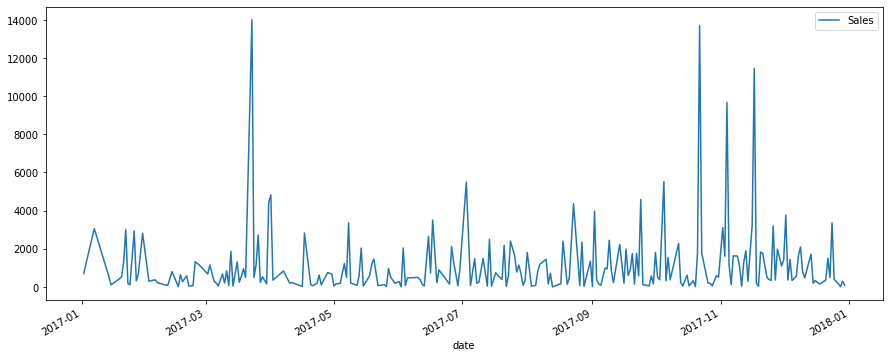

In [77]:
# test data set
test02.plot(figsize=(15, 6))
plt.show()

***
### Model 1: Naive Approach

If we want to forecast the sales for the next day, we can simply take the last day sales and estimate the same sales for the next day. Such forecasting technique which assumes that the next expected point is equal to the last observed point is called Naive Method.

<img src="https://raw.githubusercontent.com/susanqisun/AIM5010/master/01.png">

https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

Now I will implement the Naive method to forecast the sales for test data.


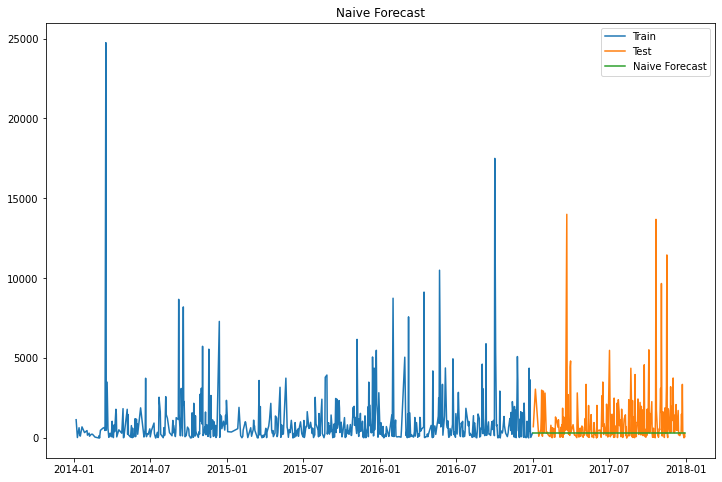

In [105]:
dd= np.asarray(train02.Sales)
y_hat = test02.copy()
y_hat['naive'] = dd[len(dd)-1]

plt.figure(figsize=(12,8))
plt.plot(train02.index, train02['Sales'], label='Train')
plt.plot(test02.index,test02['Sales'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

#### Model Evaluation

I will calculate RMSE to check to accuracy of our model on test data set.


In [106]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# calculate RMSE 
rms = sqrt(mean_squared_error(test02.Sales, y_hat.naive))
print(rms)

1984.1617246655549


***
### Model 2 – Moving Average

Using the sales of the initial period would highly affect the forecast for the next period. Therefore as an improvement over simple average, we will take the average of the sales for last few time periods only. Such forecasting technique which uses window of time period for calculating the average is called Moving Average technique.

<img src="https://raw.githubusercontent.com/susanqisun/AIM5010/master/02.png">



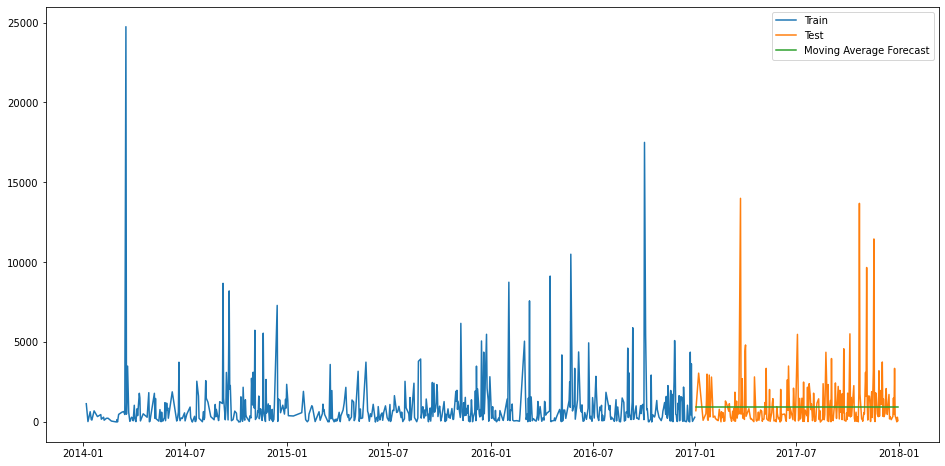

In [80]:
y_hat_avg = test02.copy()
y_hat_avg['moving_avg_forecast'] = train02['Sales'].rolling(60).mean().iloc[-1]

plt.figure(figsize=(16,8))
plt.plot(train02['Sales'], label='Train')
plt.plot(test02['Sales'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()


#### Model Evaluation


In [81]:
# calculate RMSE 
rms = sqrt(mean_squared_error(test02.Sales, y_hat_avg.moving_avg_forecast))
print(rms)


1814.6304244905514


***

### Model 3 – `Holt’s Linear Trend method` and `Holt-Winters Method`

The Naive method would assume that trend between last two points is going to stay the same. But we need a method that can map the trend accurately without any assumptions. Such a method that takes into account the trend of the dataset is called `Holt’s Linear Trend method`.

Each Time series dataset can be decomposed into it’s componenets which are Trend, Seasonality and Residual. Any dataset that follows a trend can use Holt’s linear trend method for forecasting.

However, the above mentioned model does not take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future sales. One such algorithm that we can use in such a scenario is `Holt’s Winter method`. The idea behind triple exponential smoothing(Holt’s Winter) is to apply exponential smoothing to the seasonal components in addition to level and trend.



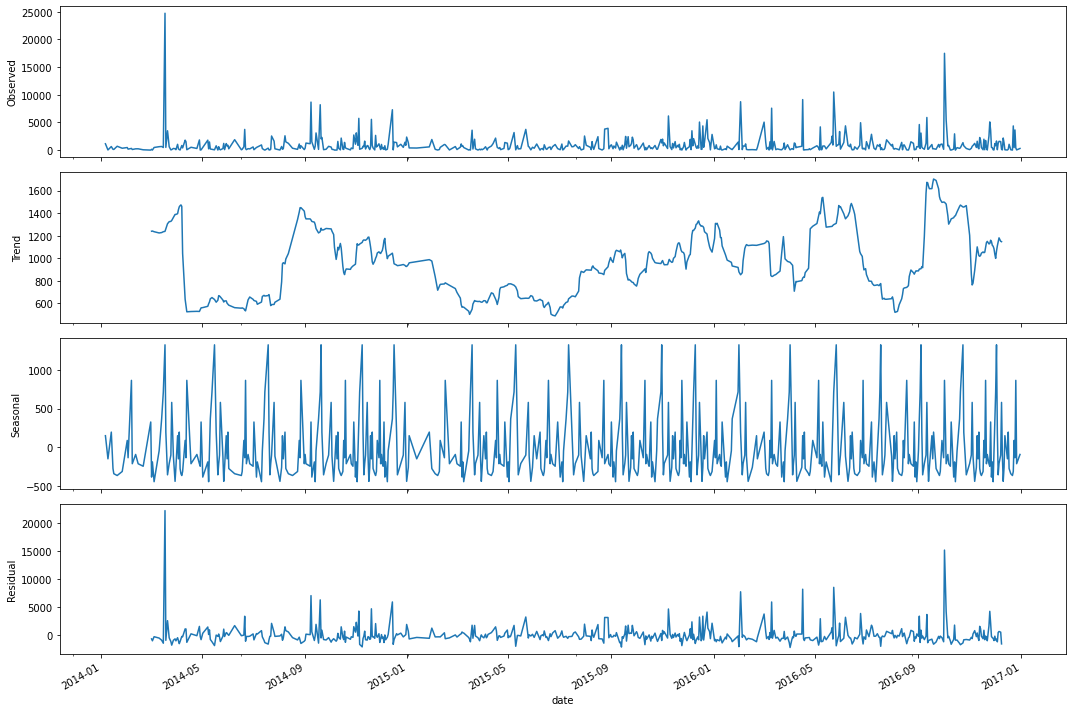

In [110]:
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (15, 10)

sm.tsa.seasonal_decompose(train02.Sales, freq=30).plot()
result = sm.tsa.stattools.adfuller(train02.Sales)

plt.show()

**Findings:**

1. We can see from the graphs above that this dataset does not follow an increasing trend. Hence we cannot use Holt’s linear trend to forecast the future sales. Holt extended simple exponential smoothing to allow forecasting of data with a trend.

2. They also show that the sales of Technology is unstable, along with its obvious seasonality.


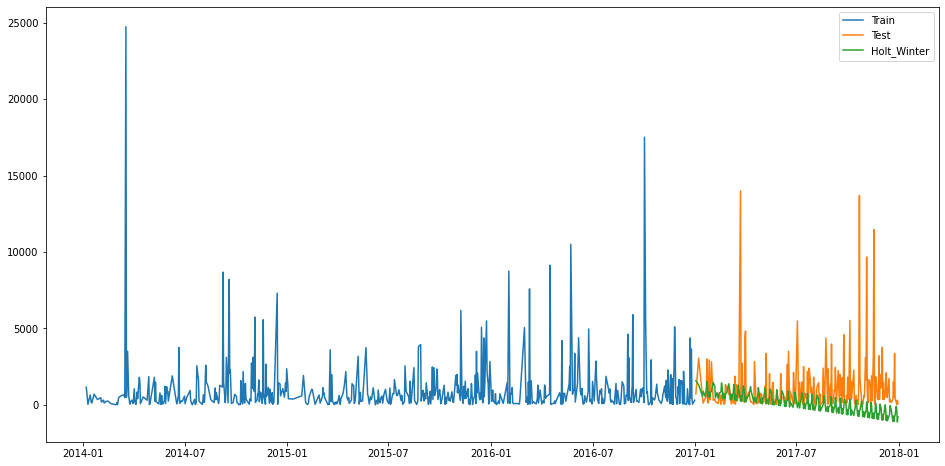

In [112]:
from statsmodels.tsa.api import ExponentialSmoothing

y_hat_avg = test02.copy()

fit1 = ExponentialSmoothing(np.asarray(train02['Sales']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test02))

plt.figure(figsize=(16,8))
plt.plot(train02['Sales'], label='Train')
plt.plot(test02['Sales'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()


#### Model Evaluation

In [113]:
# calculate RMSE 
rms = sqrt(mean_squared_error(test02.Sales, y_hat_avg.Holt_Winter))
print(rms)


2201.2225054628307


**Results:**

We can see from the graph and RMSE that seasonality did not provide a better solution.


***
### Model 4 - ARIMA

ARIMA, which stands for Autoregressive Integrated Moving Average, is the most commonly used method for time-series forecasting.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data. 

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [227]:
outer_merged = pd.merge(train, test, how="outer")
df3 = outer_merged.drop(['year'], axis=1)
df3a = df3.set_index('date')

#use the averages daily sales value for that month instead
y = df3a['Sales'].resample('MS').mean()


In [130]:
#https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The step below is parameter Selection for our technology’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.


In [217]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:791.4891765009955
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1489.3890107482791
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:549.0156237882128
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:564.1031529698099
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:542.9210079120164
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:372.6612068172691
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:750.8969484750883
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2838.4519245799534
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:535.0489454746812
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:566.0827904028189
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:526.5322595797995
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:373.8760065868637
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:729.3478530237927
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:902.8565017776876
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:562.7585881017861
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:543.3082156228088
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1386.5373314478209
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:377.03544814349607
ARIMA(

**Findings:**

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 343.6. Therefore we should consider this to be optimal option.


In [218]:
# Fitting the ARIMA model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2660      0.249     -1.067      0.286      -0.755       0.223
ma.L1         -1.0001      0.348     -2.870      0.004      -1.683      -0.317
ar.S.L12      -0.5003      0.175     -2.852      0.004      -0.844      -0.157
sigma2      2.243e+05   1.55e-06   1.44e+11      0.000    2.24e+05    2.24e+05


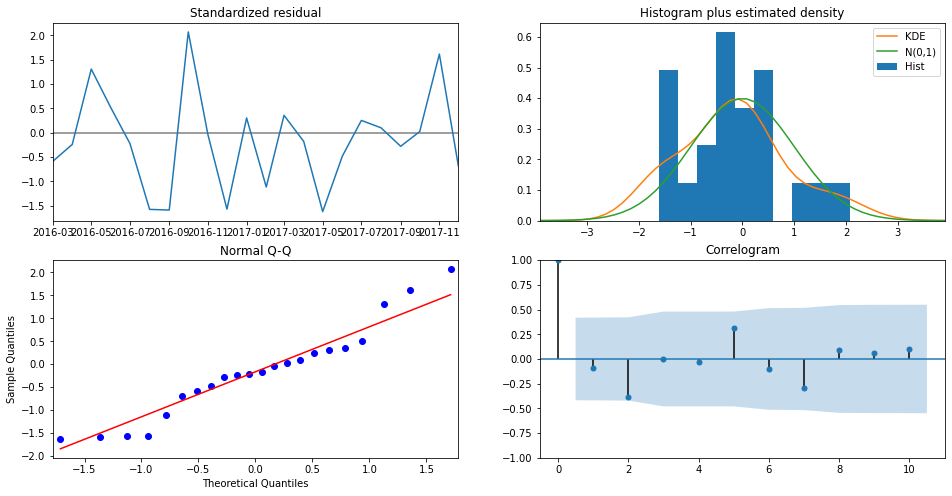

In [230]:
# run model diagnostics to investigate any unusual behavior
results.plot_diagnostics(figsize=(16, 8))
plt.show()

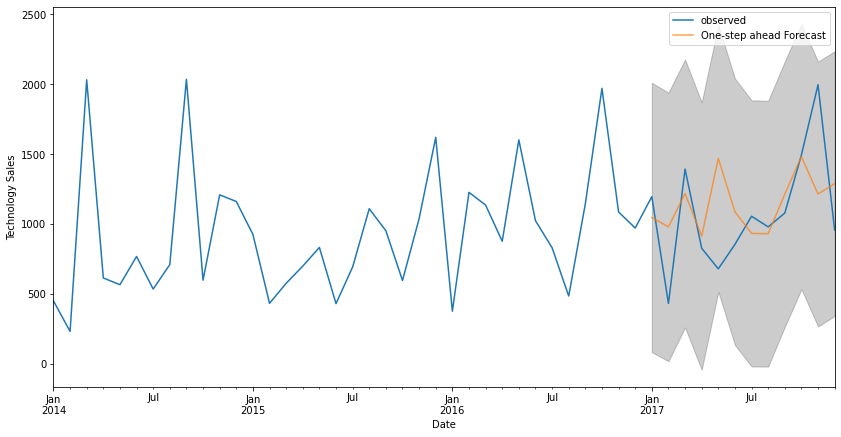

In [231]:
# Validating forecasts
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Technology Sales')
plt.legend()
plt.show()

**Results:**

The line plot above showa the observed values compared to the rolling forecast predictions. Overall, the forecasts align with the true values well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

#### Model Evaluation

In [225]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 150095.64


In [226]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 387.42


**Results:**

From all RMSE sbove, the ARIMA model has the lowest RMSE that means the best.

#### Producing and visualizing forecasts

The ARIMA model below captures technology sales seasonality.


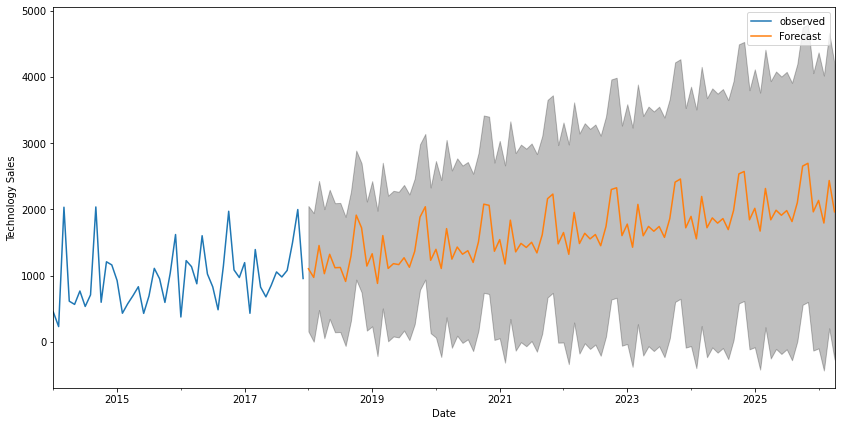

In [229]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Technology Sales')
plt.legend()
plt.show()